In [1]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [2]:
import os
import PIL
import torch
import random 
import zipfile
import numpy as np
from torch import nn
from PIL import Image
from glob import glob
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()

print(f"device: {device}")
print(torch.__version__)

device: cuda
2.1.2+cu121


# 1. Create Image Directories

In [3]:
def unzip(zip_path, image_path):
    """unzips

    Args:
        zip_path (_type_): _description_
        image_path (_type_): _description_
    """
    if Path(image_path).is_dir():
        print(f"{image_path} already exists")
    else:
        image_path.mkdir(parents=True, exist_ok=True)      
        
    if len(os.listdir(image_path)) > 0:
        print("Images already in folder") 
        pass
    else:
        with zipfile.ZipFile(zip_path, 'r') as zip_train:
            print('Unzipping Data')
            zip_train.extractall(image_path)    

In [4]:
project_directory = Path('G:/Projects/FSRCNN-2016/')

zip_data_path = Path(os.path.join(project_directory, 'zips'))
image_data_path = Path(os.path.join(project_directory, 'images'))

train_zip_path =  Path(os.path.join(zip_data_path, 'DIV2K_train_HR.zip'))
train_image_path =  Path(os.path.join(image_data_path, 'train_images'))

valid_zip_path = Path(os.path.join(zip_data_path, 'DIV2K_valid_HR.zip'))
valid_image_path = Path(os.path.join(image_data_path, 'valid_images'))

unzip(train_zip_path, train_image_path)
unzip(valid_zip_path, valid_image_path)

G:\Projects\FSRCNN-2016\images\train_images already exists
Images already in folder
G:\Projects\FSRCNN-2016\images\valid_images already exists
Images already in folder


In [5]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

walk_through_dir(image_data_path)

There are 2 directories and 6 images in G:\Projects\FSRCNN-2016\images
There are 1 directories and 0 images in G:\Projects\FSRCNN-2016\images\train_images
There are 0 directories and 800 images in G:\Projects\FSRCNN-2016\images\train_images\DIV2K_train_HR
There are 1 directories and 0 images in G:\Projects\FSRCNN-2016\images\valid_images
There are 0 directories and 100 images in G:\Projects\FSRCNN-2016\images\valid_images\DIV2K_valid_HR


In [6]:
image_path_list = list(train_image_path.glob("*/*.png"))
random_img = random.choice(image_path_list)

im = Image.open(random_img)
im_height = im.height
im_width = im.width
print(f"Image type is {type(im)}")
print(f"Image size is {im_height, im_width}")
# im

Image type is <class 'PIL.PngImagePlugin.PngImageFile'>
Image size is (1356, 2040)


# 2. Transforms

In [7]:
from torchvision.transforms import v2, InterpolationMode
from torchvision import transforms
import matplotlib.pyplot as plt

# n = 2

# img_transform = v2.Compose([
#     v2.ToPILImage(),
#     v2.Resize(size=((int(im_height/2)), (int(im_width/2))), interpolation=InterpolationMode.BICUBIC),
#     # v2.RandomPerspective(distortion_scale=0.1, p = 0.33),
#     v2.RandomChoice([
#     v2.RandomRotation(degrees=90),
#     v2.RandomRotation(degrees=180),
#     v2.RandomRotation(degrees=270),]
#     # v2.RandomCrop(size=(int((int(im_height/2))*.8),int((int(im_width/2))*.8)))]
#     , p=[0.33, .33, .33]),
#     # v2.PILToTensor(),
#     transforms.ToTensor()
#                             ])

In [8]:
def train_transform_LR_image(self, image):
    im_height = image.height
    im_width = image.width
    train_img_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(size=((int(im_height/self.n)), (int(im_width/self.n))), interpolation=InterpolationMode.BICUBIC),
        # v2.RandomPerspective(distortion_scale=0.1, p = 0.33),
        v2.RandomChoice([
        v2.RandomRotation(degrees=90),
        v2.RandomRotation(degrees=180),
        v2.RandomRotation(degrees=270)]
        , p=[0.33, .33, .33])
        ,
        # v2.RandomApply([
        #     v2.RandomCrop(size=(int((int(im_height/self.n))*.8),int((int(im_width/self.n))*.8)))
        # ], p=.3)
        # ,
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                ])
    return img_transform(image)

def test_transform_LR_image(self, image):
    im_height = image.height
    im_width = image.width
    test_img_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(size=((int(im_height/self.n)), (int(im_width/self.n))), interpolation=InterpolationMode.BICUBIC),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ])
    
def transform_HR_image(self, image):
    HR_img_transform = v2.Compose([
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    ])
    return img_transform(image)

In [9]:
n=2
train_img_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(size=((int(im_height//n)), (int(im_width//n))), interpolation=InterpolationMode.BICUBIC),
        # v2.RandomPerspective(distortion_scale=0.1, p = 0.33),
        v2.RandomChoice([
        v2.RandomRotation(degrees=90),
        v2.RandomRotation(degrees=180),
        v2.RandomRotation(degrees=270)]
        , p=[0.33, .33, .33])
        ,
        # v2.RandomApply([
        #     v2.RandomCrop(size=(int((int(im_height/self.n))*.8),int((int(im_width/self.n))*.8)))
        # ], p=.3)
        # ,
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                ])

test_img_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize(size=((int(im_height/n)), (int(im_width/n))), interpolation=InterpolationMode.BICUBIC),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ])

hr_img_transform = v2.Compose([
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
    ])

# Augment the Images

In [10]:
augmented_image_path = Path(os.path.join(project_directory, 'augmented_images'))
if augmented_image_path.is_dir():
        print(f"{augmented_image_path} already exists")
else:
    augmented_image_path.mkdir(parents=True, exist_ok=True)

G:\Projects\FSRCNN-2016\augmented_images already exists


In [11]:
import h5py
import numpy as np
from pathlib import Path
import cv2
from glob import glob


def augment_images(in_path, out_path, subclass):
    
    augmented_image_path = Path(os.path.join(project_directory, 'augmented_images'))
    subclass_dir = Path(os.path.join(augmented_image_path, subclass))
    if subclass_dir.is_dir():
        print(f"{augmented_image_path}/{subclass} already exists")
        
    else:
        subclass_dir.mkdir(parents=True, exist_ok=True)
        
        
    if len(os.listdir(subclass_dir)) > 0:
        print(f"files already loaded into {str(out_path)}\{subclass}")
        pass
    
    else:
    
        train_augmented = []
        
        og_train_images = list(glob(os.path.join(in_path, f"*/*.png")))
        for image_path in og_train_images:
            path_str = str(image_path)
            path_name = os.path.basename(path_str).split('.')[0]
            image = cv2.imread(image_path)
            for scale in [1.0, 0.9, 0.8, 0.7, 0.6]:
                for rotation in [0, 90, 180, 270]:
                    augmented_image_path = os.path.join(out_path, subclass, f"{path_name}_{1 if str(scale).split('.')[1] == '0' else str(scale).split('.')[1]}_{rotation}.png")
                    augmented = cv2.resize(src=image, 
                                        dsize=(int(image.shape[0] * scale), 
                                        int(image.shape[1] * scale)), 
                                        interpolation=cv2.INTER_CUBIC)
                    image_center = tuple(np.array(image.shape[1::-1]) / 2)
                    rot_mat = cv2.getRotationMatrix2D(image_center, rotation, 1.0)
                    augmented = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_CUBIC)
                    # augmented = augmented.rotate(rotation, expand=True)
                    # train_augmented.append(augmented)
                    cv2.imwrite(augmented_image_path, augmented)
                    
        print(f"Finished Loading Images {out_path}\{subclass}")
            
augment_images(in_path=train_image_path,
               out_path=augmented_image_path,
               subclass='train')

augment_images(in_path=valid_image_path,
               out_path=augmented_image_path,
               subclass='valid')

G:\Projects\FSRCNN-2016\augmented_images/train already exists
files already loaded into G:\Projects\FSRCNN-2016\augmented_images\train
G:\Projects\FSRCNN-2016\augmented_images/valid already exists
files already loaded into G:\Projects\FSRCNN-2016\augmented_images\valid


# Create the custom Datasets

In [12]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple
import pathlib


class TrainDIV2K(Dataset):
    
    def __init__(self, dir_path:str, scale=2):
        super().__init__()
        # get images from a path
        self.paths = list(pathlib.Path(dir_path).glob(f"*.png"))
        self.scale = scale

    def load_image(self, idx:int) -> Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path).convert('RGB')
    
    def train_transform(self, image):
        im_height = (image.height // self.scale) * self.scale
        im_width = (image.width // self.scale) * self.scale
        train_img_transform = v2.Compose([
            v2.ToPILImage(),
            v2.Resize(size=((int(im_height//self.scale)), (int(im_width//self.scale))), interpolation=InterpolationMode.BICUBIC),
            v2.Grayscale(num_output_channels=1),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])])
        
        hr_img_transform = v2.Compose([
            v2.Grayscale(num_output_channels=1),
            v2.Resize(size=(im_height, im_width), interpolation=InterpolationMode.BICUBIC),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
        ])
        
        return train_img_transform(image), hr_img_transform(image)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the LR and HR images given an index

        Args:
            idx (int): Index of image

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: returns images in forms of tensors
        """
        img = self.load_image(idx)
        LR, HR = self.train_transform(img)
        return torch.Tensor(np.expand_dims(LR / 255., 0)).squeeze(0), torch.Tensor(np.expand_dims(HR / 255., 0)).squeeze(0)

In [13]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from typing import Tuple
import pathlib


class EvalDIV2K(Dataset):
    
    def __init__(self, dir_path:str, scale=2):
        super().__init__()
        # get images from a path
        self.paths = list(pathlib.Path(dir_path).glob(f"*.png"))
        self.scale = scale

    def load_image(self, idx:int) -> Image.Image:
        image_path = self.paths[idx]
        return Image.open(image_path).convert('RGB')
    
    def test_transform(self, image):
        im_height = (image.height // self.scale) * self.scale
        im_width = (image.width // self.scale) * self.scale
        test_img_transform = v2.Compose([
            v2.ToPILImage(),
            v2.Resize(size=((int(im_height//self.scale)), (int(im_width//self.scale))), interpolation=InterpolationMode.BICUBIC),
            v2.Grayscale(num_output_channels=1),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
        ])
        
        hr_img_transform = v2.Compose([
            v2.Grayscale(num_output_channels=1),
            v2.Resize(size=(im_height, im_width), interpolation=InterpolationMode.BICUBIC),
            v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
        ])
        
        return test_img_transform(image), hr_img_transform(image)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, idx:int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the LR and HR images given an index

        Args:
            idx (int): Index of image

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: returns images in forms of tensors
        """
        img = self.load_image(idx)
        LR, HR = self.test_transform(img)
        return torch.Tensor(np.expand_dims(LR / 255., 0)).squeeze(0), torch.Tensor(np.expand_dims(HR / 255., 0)).squeeze(0)

In [14]:
augmented_image_path_train = Path(os.path.join(augmented_image_path, 'train'))
augmented_image_path_valid = Path(os.path.join(augmented_image_path, 'valid'))

augmented_image_path_train, augmented_image_path_valid, len(os.listdir(augmented_image_path_valid)), len(os.listdir(augmented_image_path_train))

(WindowsPath('G:/Projects/FSRCNN-2016/augmented_images/train'),
 WindowsPath('G:/Projects/FSRCNN-2016/augmented_images/valid'),
 2000,
 16000)

In [15]:
# len(os.listdir(augmented_image_path_train))
len(list(pathlib.Path(augmented_image_path_train).glob(f"*.png")))

16000

In [16]:
train_data_custom = TrainDIV2K(dir_path=augmented_image_path_train,
                               scale=2)

valid_data_custom = EvalDIV2K(dir_path=augmented_image_path_valid,
                               scale=2)

print(f"Length of training data: {len(train_data_custom)}")
print(f"Length of Validation data: {len(valid_data_custom)}")

Length of training data: 16000
Length of Validation data: 2000


In [17]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                    #  num_workers=NUM_WORKERS,
                                     shuffle=True
                                     )

eval_dataloader_custom = DataLoader(dataset=valid_data_custom,
                                     batch_size=BATCH_SIZE,
                                    #  num_workers=NUM_WORKERS,
                                     shuffle=False)

In [18]:
LR_custom, HR_custom = next(iter(eval_dataloader_custom))

LR_custom.shape, HR_custom.shape

(torch.Size([1, 1, 678, 1020]), torch.Size([1, 1, 1356, 2040]))

# 4. Display Images

In [19]:
from einops.layers.torch import Rearrange

def plot_transformation(idx, data, n=3):
    """
    input:
        path_list: list of paths
        transform: a transform function
        n: the number of images to display
    output:
        displays random images in pairs of the original and transformed image
    """
    plt.figure(figsize=(30,20))
    random_images = random.sample(range(len(data)), n)
    for img in random_images:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        images = data.__getitem__(img)
        # OG image
        # image_0 = Rearrange('h w c -> h w c')(images[0])
        ax[0].imshow(images[1].squeeze(0))
        ax[0].set_title(f"Original")
        ax[0].axis(False)
        
        # Transformed image
        # image_1 = Rearrange('h w c -> h w c')(images[1])
        ax[1].imshow(images[0].squeeze(0))
        ax[1].set_title(f"Downsampled")
        ax[1].axis(False)

<Figure size 3000x2000 with 0 Axes>

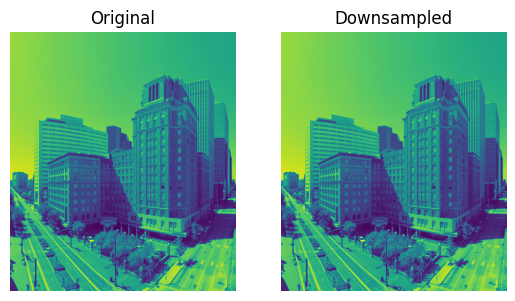

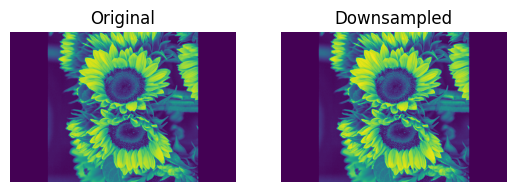

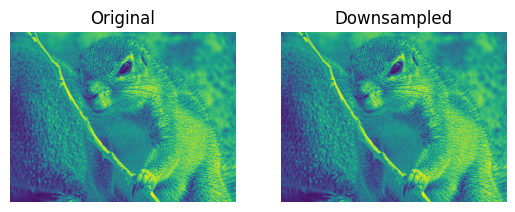

In [20]:
plot_transformation(idx=3,
                    data=train_data_custom)

# Create the model 

In [21]:
from torch import nn
import math 

class FSRCNN(nn.Module):
    """
    Model from https://arxiv.org/abs/1608.00367
    """
    def __init__(self, scale:int, num_channels=1, d=56, s=12, m=4):
        """
        d: LR feature dimension
        s: level of shrinking
        m: number of mapping layers
        n: scaling factor
        """
        super().__init__()
        if scale < 2  and scale > 5:
            raise ValueError("Scaling must be 2, 3, or 4")
        else:
            self.scale = scale
        
        self.Conv1 = nn.Sequential(nn.Conv2d(in_channels=num_channels,
                               out_channels=d,
                               kernel_size=5,
                               padding=5//2,
                               padding_mode='zeros',
                               device=device),
                                   nn.PReLU(d))
        
        self.Conv2 = nn.Sequential(nn.Conv2d(in_channels=d,
                               out_channels=s,
                               kernel_size=1,
                               device=device),
                                   nn.PReLU(s))
        
        self.Conv3 = []
        for _ in range(m):
            self.Conv3.extend([nn.Conv2d(in_channels=s,
                               out_channels=s,
                               kernel_size=3,
                               padding=3//2,
                               padding_mode='zeros',
                               device=device),
                                nn.PReLU(s)])
        self.Conv3 = nn.Sequential(*self.Conv3)
        
        self.Conv4 = nn.Sequential(nn.Conv2d(in_channels=s,
                               out_channels=d,
                               kernel_size=1,
                               device=device),
                                   nn.PReLU(d))
        
        self.DeConv = nn.ConvTranspose2d(in_channels=d,
                                         out_channels=num_channels,
                                         kernel_size=9,
                                         stride=self.scale,
                                         padding=9//2,
                                         output_padding=self.scale-1,
                                         device=device)
        
        self._init_weights()
        
    def _init_weights(self):
        for w in self.Conv1:
            if isinstance(w, nn.Conv2d):
                nn.init.normal_(w.weight.data, mean=0.0, std=math.sqrt(2/(w.out_channels*w.weight.data[0][0].numel())))
        for w in self.Conv2:
            if isinstance(w, nn.Conv2d):
                nn.init.normal_(w.weight.data, mean=0.0, std=math.sqrt(2/(w.out_channels*w.weight.data[0][0].numel())))
        for w in self.Conv3:
            if isinstance(w, nn.Conv2d):
                nn.init.normal_(w.weight.data, mean=0.0, std=math.sqrt(2/(w.out_channels*w.weight.data[0][0].numel())))
        for w in self.Conv4:
            if isinstance(w, nn.Conv2d):
                nn.init.normal_(w.weight.data, mean=0.0, std=math.sqrt(2/(w.out_channels*w.weight.data[0][0].numel())))
        
        nn.init.normal_(self.DeConv.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.DeConv.bias.data)
            
        
    def forward(self, x):
        block1 = self.Conv1(x)
        # print(block1.shape)
        block2 = self.Conv2(block1)
        # print(block2.shape)
        block3 = self.Conv3(block2)
        # print(block3.shape)
        block4 = self.Conv4(block3)
        # print(block4.shape)
        out = self.DeConv(block4)
        return out
        

In [22]:
model_0 = FSRCNN(scale=2).to(device)

model_0

FSRCNN(
  (Conv1): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (Conv2): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
  )
  (Conv3): Sequential(
    (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): PReLU(num_parameters=12)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=12)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=12)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=12)
  )
  (Conv4): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=56)
  )
  (DeConv): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(2, 2), padding=(4, 4), output_padding=(1, 1))
)

In [23]:
# Install torch info
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

In [24]:
from torchinfo import summary

summary(model_0, input_size=[1, 1, 351, 510])

Layer (type:depth-idx)                   Output Shape              Param #
FSRCNN                                   [1, 1, 702, 1020]         --
├─Sequential: 1-1                        [1, 56, 351, 510]         --
│    └─Conv2d: 2-1                       [1, 56, 351, 510]         1,456
│    └─PReLU: 2-2                        [1, 56, 351, 510]         56
├─Sequential: 1-2                        [1, 12, 351, 510]         --
│    └─Conv2d: 2-3                       [1, 12, 351, 510]         684
│    └─PReLU: 2-4                        [1, 12, 351, 510]         12
├─Sequential: 1-3                        [1, 12, 351, 510]         --
│    └─Conv2d: 2-5                       [1, 12, 351, 510]         1,308
│    └─PReLU: 2-6                        [1, 12, 351, 510]         12
│    └─Conv2d: 2-7                       [1, 12, 351, 510]         1,308
│    └─PReLU: 2-8                        [1, 12, 351, 510]         12
│    └─Conv2d: 2-9                       [1, 12, 351, 510]         1,308
│ 

In [25]:
# single image batch
LR_single, HR_single = next(iter(train_data_custom))
LR_single.shape, HR_single.shape

(torch.Size([1, 702, 1020]), torch.Size([1, 1404, 2040]))

In [26]:
LR_single.unsqueeze(0).shape

torch.Size([1, 1, 702, 1020])

In [27]:
example_y = model_0(LR_single.unsqueeze(0).to(device))
example_y.shape

torch.Size([1, 1, 1404, 2040])

# Train Model

1. first train on simple model with only downsampled training data
2. few epochs no batches
3. create my own batches by making a list of lists or something

- for an epoch in a range
- do a forward pass
- calculate the loss
- optimizer zero_grad
- loss backward
- optimizer step

In [28]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
    """
    Trains one batch of images and returns the loss
    """
    # Initialize training loss
    train_loss = 0

    model.train()
        
    for batch, (X, y) in enumerate(dataloader):
        # Put on correct device
        X, y = X.to(device), y.to(device)
        
        # Forward Pass
        train_pred = model(X)
        
        # Calculate Loss
        loss = loss_fn(train_pred, y)
        train_loss += loss.item()
        
        # Optimizer zero grad
        optimizer.zero_grad()
        
        # Loss Backward
        loss.backward()
        
        # Optimizer Step
        optimizer.step()
        
    return train_loss

g:\Anaconda\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    
    # Put in eval mode
    model.eval()

    # Initialize test loss
    test_loss = 0

    # Put in inference mode
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            # Put data on correct device
            X, y = X.to(device), y.to(device)
            
            # Forward Pass
            test_pred = model(X)
            
            # Calculate loss
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            
    test_loss /= len(dataloader)

    return test_loss

In [30]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device=device):
    
      results = {'train_loss': [],
                  'test_loss': []}

      for epoch in tqdm(range(epochs)):
            train_loss = train_step(
                  model=model,
                  dataloader=train_dataloader,
                  loss_fn=loss_fn,
                  optimizer=optimizer,
                  device=device
            )
            
            test_loss = test_step(
                  model=model,
                  dataloader=test_dataloader,
                  loss_fn=loss_fn,
                  device=device
            )
            
            results['train_loss'].append(train_loss)
            results['test_loss'].append(test_loss)
            
            print(f"Epoch: {epoch}  || Train Loss: {train_loss:.4f} || Test Loss: {test_loss:.4f}")
            
            
      return results

In [31]:
device

'cuda'

In [32]:
optimizer = torch.optim.SGD(params=model_0.parameters(),
                     lr=1e-3)
loss_fn = nn.MSELoss()

train(model=model_0,
      train_dataloader=train_dataloader_custom,
      test_dataloader=eval_dataloader_custom,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=1,
      device=device)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [59:36<00:00, 3576.49s/it]

Epoch: 0  || Train Loss: 0.0222 || Test Loss: 0.0000


{'train_loss': [0.02220032457900345], 'test_loss': [1.3428694991688417e-06]}

# Calculate PSNR

In [33]:
def calc_psnr(img1, img2):
    return 10. * torch.log10(1. / torch.mean((img1 - img2) ** 2))

best_psnr = 0.0
avg_psnr = 0.0

for idx, (X, y) in tqdm(enumerate(eval_dataloader_custom)):
    X, y = X.to(device), y.to(device)
    
    pred = model_0(X)
    
    psnr = calc_psnr(pred, y)
    
    # avg_psnr += psnr
    
    if psnr > best_psnr:
        best_psnr = psnr
        best_psnr_idx = idx
    
# avg_psnr /= len(eval_dataloader_custom)

print(f'Best PSNR: {best_psnr}')

2000it [06:30,  5.13it/s]

Best PSNR: 64.06761932373047
